# EVI prediction_using_bayesian_NN&LSTM

## Objetive:

To investigate the trend and pattern of time seriese data (MODIS data) using the Long Short Term Memory (LSTM) networks 
and quantify the uncertianty of the time series prediction of target variables. 

There are multiple [sources](https://towardsdatascience.com/extreme-event-forecasting-with-lstm-autoencoders-297492485037) you can refer to dive into the Bayesian Netural Networks (BNN) and their revelant applications.

This application is inspired by the paper published by Uber and you can find detailed information on their application [here](https://eng.uber.com/neural-networks-uncertainty-estimation/).

In [1]:
## import packages
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import random
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

## 1 Data import

In [3]:
dat = pd.read_csv("./data/new_ndvi_evi_qa_lc_nl_gelderland_loobos_2000_2020.csv",date_parser='time')

In [4]:
dat.head()

,pixel,year,ndvi,evi,qa,lai,time,land_cover,lc_time
0,1,2001,0.526821,0.256073,1.0,0.102631,2001-10-16,7.0,2001-01-01
1,1,2001,0.628324,0.265603,1.0,0.141775,2001-12-03,7.0,2001-01-01
2,1,2001,0.699998,0.368226,0.0,0.174447,2001-08-29,7.0,2001-01-01
3,1,2001,0.634201,0.330407,1.0,0.091480,2001-09-14,7.0,2001-01-01
4,1,2001,0.533343,0.302017,0.0,0.182181,2001-06-26,7.0,2001-01-01


In [5]:
dat['Date'] = pd.to_datetime(dat['time'])

In [6]:
dat = dat.set_index('Date')

In [7]:
dat.head()

,pixel,year,ndvi,evi,qa,lai,time,land_cover,lc_time
Date,,,,,,,,,
2001-10-16,1,2001,0.526821,0.256073,1.0,0.102631,2001-10-16,7.0,2001-01-01
2001-12-03,1,2001,0.628324,0.265603,1.0,0.141775,2001-12-03,7.0,2001-01-01
2001-08-29,1,2001,0.699998,0.368226,0.0,0.174447,2001-08-29,7.0,2001-01-01
2001-09-14,1,2001,0.634201,0.330407,1.0,0.091480,2001-09-14,7.0,2001-01-01
2001-06-26,1,2001,0.533343,0.302017,0.0,0.182181,2001-06-26,7.0,2001-01-01


## 2 Data overview

In [8]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502550 entries, 2001-10-16 to 2019-12-03
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   pixel       502550 non-null  int64  
 1   year        502550 non-null  int64  
 2   ndvi        502550 non-null  float64
 3   evi         502550 non-null  float64
 4   qa          502550 non-null  float64
 5   lai         502550 non-null  float64
 6   time        502550 non-null  object 
 7   land_cover  476100 non-null  float64
 8   lc_time     476100 non-null  object 
dtypes: float64(5), int64(2), object(2)
memory usage: 38.3+ MB


In [9]:
dat['pixel'].nunique() ##There ae 1150 locations

1150

In [10]:
dat.shape

(502550, 9)

In [11]:
### PLOT SERIES FOR SINGLE MARKET OF SELECTED AVOCADO TYPE ###
def plot_seris(df,pixel, scols):
    
    plt.figure(figsize=(20,10))
    reg_train = df[(df['pixel']==pixel)& (df['year'] <2017)]
    
    p_train = reg_train[scols]
    reg_train[scols].plot()
    
    
    reg_test = df[(df['pixel']==pixel)& (df['year'] >=2017)]
    
    p_test = reg_test[scols]
    reg_test[scols].plot()
    
   
    plt.title('modis variables at location pixel= '+ str(pixel))
    plt.show()

<Figure size 1440x720 with 0 Axes>

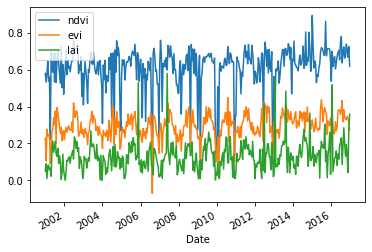

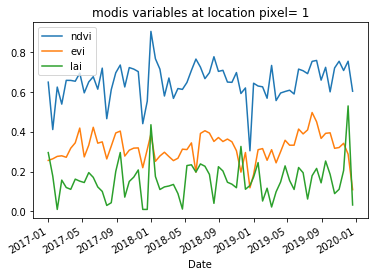

In [12]:
plot_seris(dat,pixel=1,scols = ['ndvi','evi','lai'])

## 3 Data QA/AC

1 As we noticed, there is one layer called QA (should be within[0,1]) which include the quality information of the pixels at different time. we will first use them to conduct filtering.

2 if we have land cover type data, we can used that as a filter, we need to chose land cover type for vegetation from 1 to 10 and 12. You can refer to [here](https://lpdaac.usgs.gov/documents/101/MCD12_User_Guide_V6.pdf) for the land cover classification information

In [13]:
##filter based on quality information, it should be within 0 and 1
dat['qa'] = dat['qa'].apply(lambda x: x if x>=0 and x<=1 else None)

dat['land_cover'] = dat['land_cover'].apply(lambda x: x if x>=1 and x<=10 or x ==12 else None )

In [14]:
sum_pixel = dat.groupby('pixel').count()

In [15]:
sum_pixel

,year,ndvi,evi,qa,lai,time,land_cover,lc_time
pixel,,,,,,,,
1,437,437,437,387,437,437,414,414
2,437,437,437,380,437,437,414,414
3,437,437,437,387,437,437,414,414
4,437,437,437,380,437,437,414,414
5,437,437,437,387,437,437,414,414
...,...,...,...,...,...,...,...,...
1146,437,437,437,379,437,437,414,414
1147,437,437,437,365,437,437,414,414
1148,437,437,437,376,437,437,414,414


In [16]:
sel_pixel = list(sum_pixel[sum_pixel['qa'] == sum_pixel['qa'].max()].index)

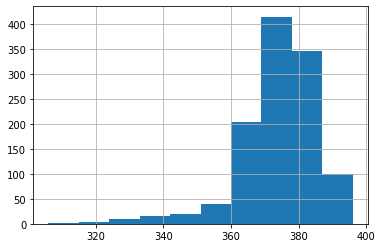

In [17]:
sum_pixel['qa'].hist()

In [18]:
dat['time'].nunique()

437

### Low quality values

We can see that there are a lot of abnormal values or outliers.
Thus, we need to filter them ased on the QA column. 

There are two strategies to process these low quality or abnormal values

    1 to remove them

    2 to fill them with mean of nearby locations

In [19]:
## deal with low quality values, to keep more data for following modelling, used second strategry: replace the missing values with neighbours
def lw_process(df,cols,qual_col = "qa",strategies = "fill"):
    for col in cols:
        if strategies != "fill":
            df[col] = df[df[qual_col].notnull()][col]
        else:
            df.loc[df[qual_col].isnull(),col] = None
            ##replace with neighbours
            df[col] = (df[col].fillna(method = 'ffill') + df[col].fillna(method = 'bfill'))/2
    return df        

In [20]:
df1 = lw_process(dat,cols = ['ndvi','evi','lai'])

## 4 Data format preparation

In [21]:
## I will select part of locations with high quality points, this can ensure our input data have higher quality,
## and at the same time we can reduce the the data volume as we have a very large datasets

## we will select quality values in one pixel has more than mean of quality column + 10 

sel_pixels = list(sum_pixel[sum_pixel['qa'] > sum_pixel['qa'].mean()+10].index)

In [22]:
df = df1[df1['pixel'].isin(sel_pixels)]

In [23]:
df['pixel'].nunique()

209

In [24]:
df.shape

(91333, 9)

### Generate sequence data with the required format [batchsize, time step, number of features]

In [25]:
## the follwoing function is more general which can deal with multiple dimensions

def to_sequences_MD (seq_size,obs,xcols,ycol,step=1):
    x = []
    y = []
    y_time = []
    
    for i in range(0,len(obs)-SEQUENCE_SIZE,step):
        '''
        seq_size: the number of observations will be used for training, time step
        step: the step of time moving window, change of observations to form a new training data, default is 1 
        obs: the original dataset
        xcols: the column names of X
        ycol: the column nam of Y
        '''
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)][xcols]
        after_window = obs[(i+SEQUENCE_SIZE -1):(i+SEQUENCE_SIZE)][ycol]
        #window = [[x] for x in window]
        time_index = after_window.index.values[0]
        win_values = window.values
        #print("{} - {}".format(window,after_window))
        x.append(win_values)
        y.append(after_window.values)
        y_time.append(time_index)
        
    return np.array(x),np.array(y),y_time

### Model uncertanty data preparation on target variable - EVI

In [26]:
## our target is evi (Y), the ndvi and lai will used for external variables (X)

## I have about 20 years data and 0.8 for training, thus set date 2016

SEQUENCE_SIZE = 10 ##timestep

sel_date= "2016-01-01" ##split training and test 

val_pixel = df['pixel'].nunique() - 9 ##threshold for hold out data 

In [27]:
pixel_thres = sel_pixels[val_pixel]

In [28]:
xcol = ['evi']
ycol = ['evi']

In [29]:
df_x_train =[]
df_x_test =[]
df_y_train =[]
df_y_test =[]

##hold out datasets based on the pixel or locations
val_x_train =[]
val_x_test =[]
val_y_train =[]
val_y_test =[]

for pixel in sel_pixels:
    
    sub_df = df[df['pixel'] == pixel]
    sub_train = sub_df[sub_df.index < sel_date]
    sub_test = sub_df[sub_df.index >= sel_date ]
    
    x_train,y_train,train_time = to_sequences_MD(SEQUENCE_SIZE,sub_train, xcols =xcol,ycol=ycol)
    x_test,y_test,test_time = to_sequences_MD(SEQUENCE_SIZE,sub_test, xcols =xcol,ycol=ycol)
    
    if pixel <= pixel_thres:
        
        df_x_train.append(x_train)
        df_x_test.append(x_test)
    
        df_y_train.append(y_train)
        df_y_test.append(y_test)
        
    else:
        val_x_train.append(x_train)
        val_x_test.append(x_test)
    
        val_y_train.append(y_train)
        val_y_test.append(y_test)
    
## convert to np array

df_x_train1 = np.asarray(df_x_train).reshape(-1,SEQUENCE_SIZE,len(xcol))
df_x_test1 = np.asarray(df_x_test).reshape(-1,SEQUENCE_SIZE,len(xcol))

df_y_train1 = np.asarray(df_y_train).reshape(-1,1)
df_y_test1 = np.asarray(df_y_test).reshape(-1,1)

##hold out data
val_x_train1 = np.asarray(val_x_train).reshape(-1,SEQUENCE_SIZE,len(xcol))
val_x_test1 = np.asarray(val_x_test).reshape(-1,SEQUENCE_SIZE,len(xcol))

val_y_train1 = np.asarray(val_y_train).reshape(-1,1)
val_y_test1 = np.asarray(val_y_test).reshape(-1,1)



print("Shape of x training set: {}".format(df_x_train1.shape))
print("Shape of y training set: {}".format(df_y_train1.shape))


print("Shape of x hold out set: {}".format(val_x_train1.shape))
print("Shape of y hold out set: {}".format(val_y_train1.shape))

Shape of x training set: (67335, 10, 1)
Shape of y training set: (67335, 1)
Shape of x hold out set: (2680, 10, 1)
Shape of y hold out set: (2680, 1)


### Summary of what I have done in the previous step

1 Here df_x_train is a list and each element of the list represnt a pixel or a location. In totally there are 201 locations in the training data and 335 sequence (345 - seq_size)

2 We convert the list into numpy array (four dimensions) and reshape it to three dimesion.


In [30]:
## see one example
dd = np.asarray(df_x_train)
dd.shape

(201, 335, 10, 1)

In [31]:
### CONCATENATE TRAIN/TEST DATA AND LABEL ### 
X = np.concatenate([df_x_train1,df_x_test1],axis=0)
y = np.concatenate([df_y_train1,df_y_test1],axis=0)

print(X.shape,y.shape)

(83817, 10, 1) (83817, 1)


### External features data preparation - model misspecification



In [33]:
xcols = ['ndvi','lai']
ycol = ['evi']

In [34]:
ext_x_train =[]
ext_x_test =[]
ext_y_train =[]
ext_y_test =[]

## hold out data
eval_x_train =[]
eval_x_test =[]
eval_y_train =[]
eval_y_test =[]

for pixel in sel_pixels:
    
    sub_df = df[df['pixel'] == pixel]
    sub_train = sub_df[sub_df.index < sel_date ]
    sub_test = sub_df[sub_df.index >= sel_date ]
    
    
    x_train,y_train,train_time = to_sequences_MD(SEQUENCE_SIZE,sub_train,xcols = xcols,ycol=ycol)
    x_test,y_test,test_time = to_sequences_MD(SEQUENCE_SIZE,sub_test,xcols = xcols,ycol=ycol)
    
    if pixel <= pixel_thres:
        
        ext_x_train.append(x_train)
        ext_x_test.append(x_test)

        ext_y_train.append(y_train)
        ext_y_test.append(y_test)
        
    else:
        eval_x_train.append(x_train)
        eval_x_test.append(x_test)

        eval_y_train.append(y_train)
        eval_y_test.append(y_test)

## convert to np array
ext_x_train1 = np.asarray(ext_x_train).reshape(-1,SEQUENCE_SIZE,len(xcols))
ext_x_test1 = np.asarray(ext_x_test).reshape(-1,SEQUENCE_SIZE,len(xcols))

ext_y_train1 = np.asarray(ext_y_train).reshape(-1,1)
ext_y_test1 = np.asarray(ext_y_test).reshape(-1,1)


eval_x_train1 = np.asarray(eval_x_train).reshape(-1,SEQUENCE_SIZE,len(xcols))
eval_x_test1 = np.asarray(eval_x_test).reshape(-1,SEQUENCE_SIZE,len(xcols))

eval_y_train1 = np.asarray(eval_y_train).reshape(-1,1)
eval_y_test1 = np.asarray(eval_y_test).reshape(-1,1)


print("Shape of x training set: {}".format(ext_x_train1.shape))
print("Shape of y training set: {}".format(ext_y_train1.shape))

print("Shape of x holdout set: {}".format(eval_x_train1.shape))
print("Shape of y holdout set: {}".format(eval_y_train1.shape))

Shape of x training set: (67335, 10, 2)
Shape of y training set: (67335, 1)
Shape of x holdout set: (2680, 10, 2)
Shape of y holdout set: (2680, 1)


In [35]:
### CONCATENATE TRAIN/TEST EXTERNAL FEATURES ###
Ext_features = np.concatenate([ext_x_train1,ext_x_test1],axis=0)

print(Ext_features.shape)

(83817, 10, 2)


## 5 Model

## 5.1 Model 1 - autoencoder and LSTM prediction

### 1 Autoencoder and fit - explain the misspecification part

The model first primes the network by auto feature extraction, training an LSTM Autoencoder, which is critical to capture complex time-series dynamics at scale.



In [36]:
## Define the autoencoder and fit

inputs_ae = Input(shape=(SEQUENCE_SIZE, 1))
encoded_ae = LSTM(128, return_sequences=True, dropout=0.3)(inputs_ae, training=True)
decoded_ae = LSTM(32, return_sequences=True, dropout=0.3)(encoded_ae, training=True)
out_ae = TimeDistributed(Dense(1))(decoded_ae)


sequence_autoencoder = Model(inputs_ae, out_ae)
sequence_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])

### TRAIN AUTOENCODER ###
sequence_autoencoder.fit(X[:len(df_x_train1)], X[:len(df_x_train1)], 
                         batch_size=128, epochs=100, verbose=2, shuffle=True)

Train on 67335 samples
Epoch 1/100
67335/67335 - 25s - loss: 0.0138 - mse: 0.0138
Epoch 2/100
67335/67335 - 17s - loss: 0.0077 - mse: 0.0077
Epoch 3/100
67335/67335 - 17s - loss: 0.0048 - mse: 0.0048
Epoch 4/100
67335/67335 - 17s - loss: 0.0041 - mse: 0.0041
Epoch 5/100
67335/67335 - 18s - loss: 0.0038 - mse: 0.0038
Epoch 6/100
67335/67335 - 17s - loss: 0.0036 - mse: 0.0036
Epoch 7/100
67335/67335 - 17s - loss: 0.0034 - mse: 0.0034
Epoch 8/100
67335/67335 - 17s - loss: 0.0033 - mse: 0.0033
Epoch 9/100
67335/67335 - 18s - loss: 0.0033 - mse: 0.0033
Epoch 10/100
67335/67335 - 18s - loss: 0.0032 - mse: 0.0032
Epoch 11/100
67335/67335 - 17s - loss: 0.0032 - mse: 0.0032
Epoch 12/100
67335/67335 - 18s - loss: 0.0032 - mse: 0.0032
Epoch 13/100
67335/67335 - 17s - loss: 0.0032 - mse: 0.0032
Epoch 14/100
67335/67335 - 17s - loss: 0.0032 - mse: 0.0032
Epoch 15/100
67335/67335 - 17s - loss: 0.0032 - mse: 0.0032
Epoch 16/100
67335/67335 - 17s - loss: 0.0031 - mse: 0.0031
Epoch 17/100
67335/67335 -

### 2 Encode EVI - LSTM and concatenate external features (regressors)
Features vectors are then concatenated with the new input and fed to LSTM Forecaster for
prediction.

In [37]:
## encode the original X and later this information will be used for as input 
encoder = Model(inputs_ae, encoded_ae)
XX = encoder.predict(X)
XXE = np.concatenate([XX, Ext_features], axis=2)
XXE.shape

(83817, 10, 130)

In [63]:
## The above results will be our input for the prediction model

### SPLIT TRAIN TEST ###
X_train1, X_test1 = XXE[:len(df_x_train1)], XXE[len(df_x_train1):]
y_train1, y_test1 = y[:len(df_y_train1)], y[len(df_y_train1):]

In [39]:
X_train1.shape

(67335, 10, 130)

In [40]:
XXE.shape[-1]

130

### Scaling the data based on the variables or features (each features needs to scale)

first need to convert into 2D (n_samples, n_features) and then change it back

In [42]:
### SCALE DATA ###
scaler1 = StandardScaler()
X_train1 = scaler1.fit_transform(X_train1.reshape(-1,XXE.shape[-1])).reshape(-1,SEQUENCE_SIZE,XXE.shape[-1])
X_test1 = scaler1.transform(X_test1.reshape(-1,XXE.shape[-1])).reshape(-1,SEQUENCE_SIZE,XXE.shape[-1])

### 3 Predicition model - LSTM

In [43]:
tf.random.set_seed(1)

### DEFINE FORECASTER ###
inputs1 = Input(shape=(X_train1.shape[1], X_train1.shape[2]))
lstm1 = LSTM(128, return_sequences=True, dropout=0.3)(inputs1, training=True)
lstm1 = LSTM(32, return_sequences=False, dropout=0.3)(lstm1, training=True)
dense1 = Dense(50)(lstm1)
out1 = Dense(1)(dense1)

model1 = Model(inputs1, out1)
model1.compile(loss='mse', optimizer='adam', metrics=['mse'])

### FIT FORECASTER ###
history = model1.fit(X_train1, y_train1, epochs=30, batch_size=128, verbose=2, shuffle=True)

Train on 67335 samples
Epoch 1/30
67335/67335 - 28s - loss: 0.0043 - mse: 0.0043
Epoch 2/30
67335/67335 - 23s - loss: 0.0024 - mse: 0.0024
Epoch 3/30
67335/67335 - 24s - loss: 0.0020 - mse: 0.0020
Epoch 4/30
67335/67335 - 24s - loss: 0.0019 - mse: 0.0019
Epoch 5/30
67335/67335 - 24s - loss: 0.0018 - mse: 0.0018
Epoch 6/30
67335/67335 - 25s - loss: 0.0017 - mse: 0.0017
Epoch 7/30
67335/67335 - 24s - loss: 0.0016 - mse: 0.0016
Epoch 8/30
67335/67335 - 23s - loss: 0.0016 - mse: 0.0016
Epoch 9/30
67335/67335 - 25s - loss: 0.0016 - mse: 0.0016
Epoch 10/30
67335/67335 - 23s - loss: 0.0016 - mse: 0.0016
Epoch 11/30
67335/67335 - 22s - loss: 0.0016 - mse: 0.0016
Epoch 12/30
67335/67335 - 22s - loss: 0.0016 - mse: 0.0016
Epoch 13/30
67335/67335 - 23s - loss: 0.0015 - mse: 0.0015
Epoch 14/30
67335/67335 - 23s - loss: 0.0016 - mse: 0.0016
Epoch 15/30
67335/67335 - 23s - loss: 0.0015 - mse: 0.0015
Epoch 16/30
67335/67335 - 22s - loss: 0.0015 - mse: 0.0015
Epoch 17/30
67335/67335 - 23s - loss: 0.00

### STOCHASTIC DROPOUT

In [44]:
### FUNCTION FOR STOCHASTIC DROPOUT ###
def stoc_drop1(R, enc, NN):
    '''
    R: drop out rate
    enc: encoder layer
    NN: model for prediction
    '''
    ##what does this mean, it looks like original input and dropout as encoder function
    enc_pred = np.vstack(enc([X[len(df_x_train1):], R])) 
    
    #similar to the step 2 to do concantenate
    enc_pred = np.concatenate([enc_pred, Ext_features[len(df_x_train1):]], axis=2)
    # scale as previous steps
    trans_pred = scaler1.transform(enc_pred.reshape(-1,enc_pred.shape[-1])).reshape(-1,SEQUENCE_SIZE,enc_pred.shape[-1])
    
    NN_pred = NN([trans_pred, R])
    
    return np.vstack(NN_pred)

In [45]:
### COMPUTE STOCHASTIC DROPOUT ###
scores1 = []
enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    scores1.append(mean_absolute_error(y_test1, stoc_drop1(0.5, enc, NN)))

print(np.mean(scores1), np.std(scores1))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:49<00:00,  3.49s/it]

0.02122890271476298 0.0002159761520059988


## 5.2 Model 2 - LSTM prediction (not autoencode the original EVI)

In [48]:
### CONCATENATE REGRESSORS, without using autoencoder ###
XE = np.concatenate([X, Ext_features], axis=2)
print(XE.shape)

(83817, 10, 3)


In [49]:
### SPLIT TRAIN TEST ###
X_train2, X_test2 = XE[:len(df_x_train1)], XE[len(df_x_train1):]
y_train2, y_test2 = y[:len(df_x_train1)], y[len(df_x_train1):]

In [50]:
### SCALE DATA ###
scaler2 = StandardScaler()
X_train2 = scaler2.fit_transform(X_train2.reshape(-1,X_train2.shape[-1])).reshape(-1,SEQUENCE_SIZE,X_train2.shape[-1])
X_test2 = scaler2.transform(X_test2.reshape(-1,X_train2.shape[-1])).reshape(-1,SEQUENCE_SIZE,X_train2.shape[-1])

### LSTM model -  prediction

In [51]:
tf.random.set_seed(13)
### DEFINE LSTM FORECASTER ###
inputs2 = Input(shape=(X_train2.shape[1], X_train2.shape[2]))
lstm2 = LSTM(128, return_sequences=True, dropout=0.3)(inputs2, training=True)
lstm2 = LSTM(32, return_sequences=False, dropout=0.3)(lstm2, training=True)
dense2 = Dense(50)(lstm2)
out2 = Dense(1)(dense2)

model2 = Model(inputs2, out2)
model2.compile(loss='mse', optimizer='adam', metrics=['mse'])

### FIT FORECASTER ###
history = model2.fit(X_train2, y_train2, epochs=30, batch_size=128, verbose=2, shuffle=True)

Train on 67335 samples
Epoch 1/30
67335/67335 - 23s - loss: 0.0050 - mse: 0.0050
Epoch 2/30
67335/67335 - 20s - loss: 0.0027 - mse: 0.0027
Epoch 3/30
67335/67335 - 18s - loss: 0.0026 - mse: 0.0026
Epoch 4/30
67335/67335 - 18s - loss: 0.0023 - mse: 0.0023
Epoch 5/30
67335/67335 - 18s - loss: 0.0021 - mse: 0.0021
Epoch 6/30
67335/67335 - 18s - loss: 0.0021 - mse: 0.0021
Epoch 7/30
67335/67335 - 18s - loss: 0.0020 - mse: 0.0020
Epoch 8/30
67335/67335 - 18s - loss: 0.0019 - mse: 0.0019
Epoch 9/30
67335/67335 - 18s - loss: 0.0018 - mse: 0.0018
Epoch 10/30
67335/67335 - 19s - loss: 0.0018 - mse: 0.0018
Epoch 11/30
67335/67335 - 18s - loss: 0.0018 - mse: 0.0018
Epoch 12/30
67335/67335 - 19s - loss: 0.0018 - mse: 0.0018
Epoch 13/30
67335/67335 - 20s - loss: 0.0017 - mse: 0.0017
Epoch 14/30
67335/67335 - 20s - loss: 0.0017 - mse: 0.0017
Epoch 15/30
67335/67335 - 19s - loss: 0.0016 - mse: 0.0016
Epoch 16/30
67335/67335 - 18s - loss: 0.0016 - mse: 0.0016
Epoch 17/30
67335/67335 - 18s - loss: 0.00

In [52]:
### FUNCTION FOR STOCHASTIC DROPOUT ###
def stoc_drop2(R, NN):
    
    trans_pred = scaler2.transform(XE[len(df_x_train1):].reshape(-1,XE.shape[-1])).reshape(-1,SEQUENCE_SIZE,XE.shape[-1])
    NN_pred = NN([trans_pred,R])
    
    return np.vstack(NN_pred)

In [53]:
### COMPUTE STOCHASTIC DROPOUT ###
scores2 = []
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    scores2.append(mean_absolute_error(y_test2, stoc_drop2(0.5, NN)))

print(np.mean(scores2), np.std(scores2))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]

0.02157849081420923 0.00024282763701386688


## 6 Evaluation using test data  (the location is include, but time is unseen)

In [59]:
##test and train data is based on the year (temporal), have the same pixel (201)
## validation data is based on the pixel [202-209] 8 pixels
## There are 92 times in testing and 10 is sequence size and 82 is the time window for each pixel (in total, there are 201 pixels)

tw_test = 82 ##temporal, all temporal data for a location
num_pixels = 201  #spatial

In [54]:
df_x_test1.shape

(16482, 10, 1)

In [74]:
### FUNCTION FOR STOCHASTIC DROPOUT FOR SINGLE LOCATION ###
def test_stoc_drop1(df_x_test1,df_y_test1,ext_x_test1,pixel, R, enc, NN): ##for model 1
    
    sind = tw_test*pixel
    eind = tw_test*(pixel+1)
    
    X, y, F = df_x_test1[sind:eind,],df_y_test1[sind:eind,],ext_x_test1[sind:eind,]
    
    enc_pred = np.vstack(enc([X, R]))
    enc_pred = np.concatenate([enc_pred, F], axis=2)
    trans_pred = scaler1.transform(enc_pred.reshape(-1,enc_pred.shape[-1])).reshape(-1,SEQUENCE_SIZE,enc_pred.shape[-1])
    NN_pred = NN([trans_pred, R])
    
    return np.vstack(NN_pred), y


def test_stoc_drop2(df_x_test1,df_y_test1,ext_x_test1,pixel,R, NN): ##for model 2
    
    sind = tw_test*pixel
    eind = tw_test*(pixel+1)
    
    X, y, F = df_x_test1[sind:eind,],df_y_test1[sind:eind,],ext_x_test1[sind:eind,]
    
    XF = np.concatenate([X, F], axis=2)
    trans_pred = scaler2.transform(XF.reshape(-1,XF.shape[-1])).reshape(-1,SEQUENCE_SIZE,XF.shape[-1])
    NN_pred = NN([trans_pred, R])
    
    return np.vstack(NN_pred), y

### Prediction at the single pixel - Model1

In [56]:
enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])


In [57]:
def uncertainty_model1(pixel,p =0.05,dropout_rate =0.5):
    '''
    pixel: location
    p: 1 -  confidence interval
    dropout_rate: dropout rate in the NN model
    '''
    
    pred1 = []
    
    for i in tqdm.tqdm(range(0,100)):
        
        pred1_test,y1_test = test_stoc_drop1(df_x_test1,df_y_test1,ext_x_test1,pixel, dropout_rate, enc, NN) ## at pixel 0
        pred1.append(pred1_test)
    
    pred1 = np.asarray(pred1)
    pp = pred1[:,:,0].T
    lower = np.quantile(pp,p/2,axis =1)
    upper = np.quantile(pp,1- p/2,axis =1)
    medium = np.quantile(pp,0.5,axis =1)

    fdf = pd.DataFrame({
        "true":y1_test.ravel(),
        "lower":lower,
        "medium":medium,
        "upper":upper
        })
    
    return fdf

In [60]:
pixel = 0
uncer1 = uncertainty_model1(pixel)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.73it/s]


Text(0.5, 1.0, 'LSTM + Autoender at pixel = 0')

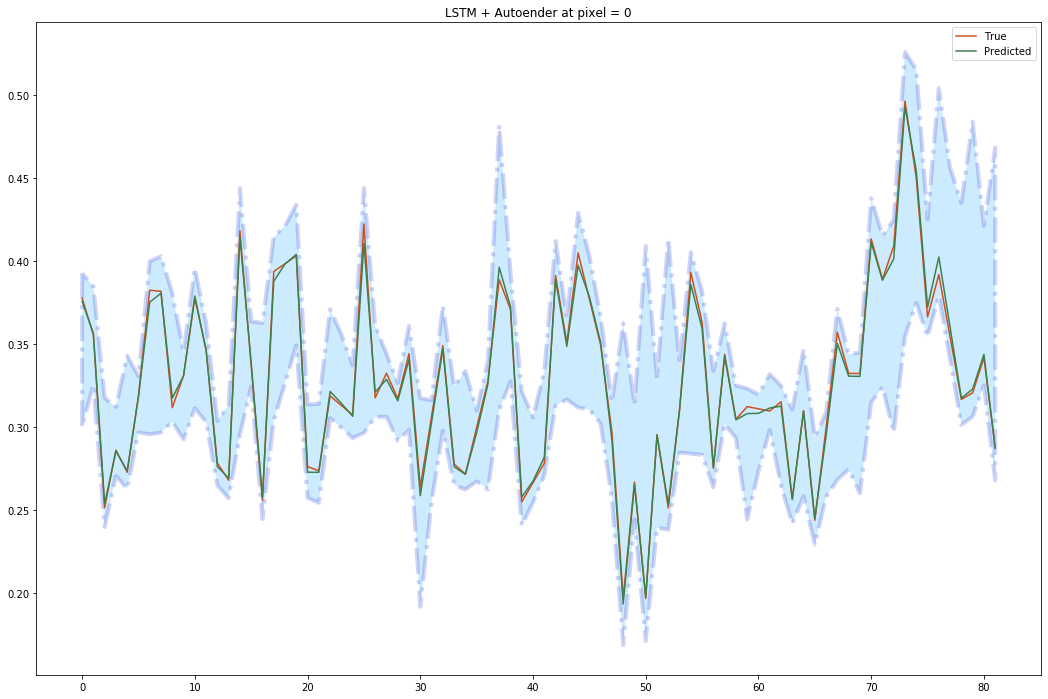

In [61]:
x = list(uncer1.index)

plt.figure(figsize=(18,12))
plt.plot(x,uncer1['true'],color='#CC4F1B')
plt.plot(x,uncer1['medium'],color = '#3F7F4C')

plt.fill_between(x,uncer1['lower'],uncer1['upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)

plt.legend(('True','Predicted'))
plt.title("LSTM + Autoender at pixel = " + str(pixel))

### summary_statistics - Uncertianty at the signle pixel - Model1

In [68]:
### COMPUTE STOCHASTIC DROPOUT FOR SINGLE COUNTY ###
mae1_test = []
enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

y1_test = test_stoc_drop1(df_x_test1,df_y_test1,ext_x_test1,pixel,0.5,enc,NN)[1] ##Single pixel location

for i in tqdm.tqdm(range(0,100)):
    
    mae1_test.append(mean_absolute_error(y1_test, test_stoc_drop1(df_x_test1,df_y_test1,ext_x_test1,pixel, 0.5, enc, NN)[0]))

print(np.mean(mae1_test), np.std(mae1_test))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.06it/s]

0.017903210724272388 0.002455354901753083


### Prediction at the single pixel - Model2

In [69]:
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])
pred2_test, y2_test = test_stoc_drop2(df_x_test1,df_y_test1,ext_x_test1,0, 0.5, NN)

In [79]:
def uncertainty_model2(pixel,p =0.05,dropout_rate =0.5):
    
    pred1 = []
    
    for i in tqdm.tqdm(range(0,100)):
        
        pred1_test,y1_test = test_stoc_drop2(df_x_test1,df_y_test1,ext_x_test1, pixel,dropout_rate, NN) ## at pixel 0
        pred1.append(pred1_test)
    
    pred1 = np.asarray(pred1)
    pp = pred1[:,:,0].T
    lower = np.quantile(pp,p/2,axis =1)
    upper = np.quantile(pp,1- p/2,axis =1)
    medium = np.quantile(pp,0.5,axis =1)

    fdf = pd.DataFrame({
        "true":y1_test.ravel(),
        "lower":lower,
        "medium":medium,
        "upper":upper
        })
    
    return fdf

In [80]:
pixel = 0
uncer2 = uncertainty_model2(pixel)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 89.00it/s]


Text(0.5, 1.0, 'LSTM model at pixel = 0')

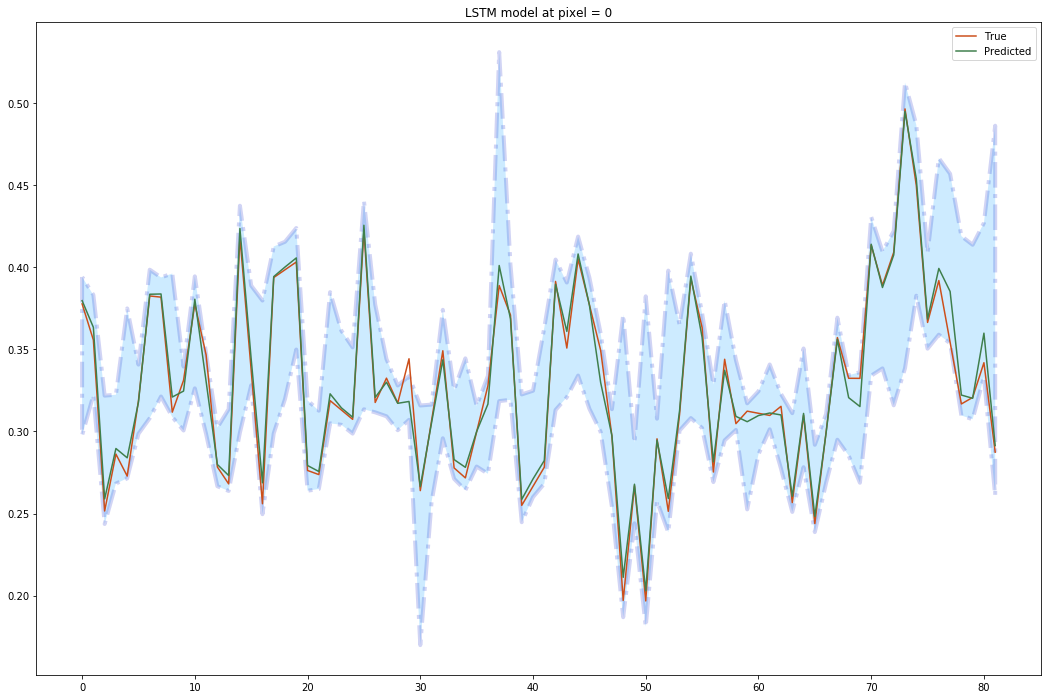

In [81]:
x = list(uncer2.index)

plt.figure(figsize=(18,12))
plt.plot(x,uncer2['true'],color='#CC4F1B')
plt.plot(x,uncer2['medium'],color = '#3F7F4C')

plt.fill_between(x,uncer2['lower'],uncer2['upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)

plt.legend(('True','Predicted'))
plt.title("LSTM model at pixel = " + str(pixel))

### summary_statistics - Uncertianty at the signle pixel - Model2

In [82]:
### COMPUTE STOCHASTIC DROPOUT FOR SINGLE COUNTY ###
mae2_test = []
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    mae2_test.append(mean_absolute_error(y2_test, test_stoc_drop2(df_x_test1,df_y_test1,ext_x_test1,0, 0.5, NN)[0]))

print(np.mean(mae2_test), np.std(mae2_test))


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 71.68it/s]

0.01777231030711316 0.0028708858980912313


### Two model comparsion -  Uncertainty plot

Text(0.5, 1.0, 'pixel =0')

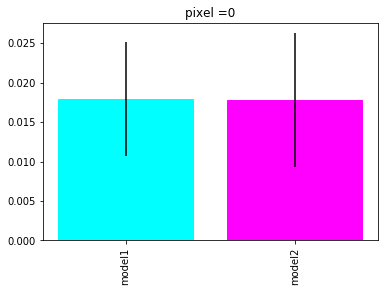

In [83]:
### PLOT AVG AND UNCERTAINTY OF RESULTS ###
bar = plt.bar([0,1], [np.mean(mae1_test), np.mean(mae2_test)], 
              yerr=[2.95*np.std(mae1_test), 2.95*np.std(mae2_test)])
plt.xticks([0,1], ['model1','model2'], rotation=90)
bar[0].set_color('cyan'), bar[1].set_color('magenta')
plt.title('pixel =0')

## 7 Evaluation using hold out data (location is unseen, time is in training data)

In [84]:
enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

### Model 1 using hold out data

In [85]:
def holdout_uncertainty_model1(pixel,p =0.05,dropout_rate =0.5):
    
    pred1 = []
    
    for i in tqdm.tqdm(range(0,100)):
        
        pred1_test,y1_test = test_stoc_drop1(df_x_test1=val_x_train1,
                                             df_y_test1=val_y_train1,
                                             ext_x_test1=eval_x_train1,
                                             pixel = pixel, 
                                             R = dropout_rate, 
                                             enc = enc, 
                                             NN = NN) ## at pixel 0
        pred1.append(pred1_test)
    
    pred1 = np.asarray(pred1)
    pp = pred1[:,:,0].T ##delete one dimension just assign one dimesion to 0
    lower = np.quantile(pp,p/2,axis =1)
    upper = np.quantile(pp,1- p/2,axis =1)
    medium = np.quantile(pp,0.5,axis =1)

    fdf = pd.DataFrame({
        "true":y1_test.ravel(),
        "lower":lower,
        "medium":medium,
        "upper":upper
        })
    
    return fdf

In [86]:
pixel = 0
holdout_uncer1 = holdout_uncertainty_model1(pixel = pixel)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.52it/s]


Text(0.5, 1.0, 'LSTM + Autoender at HOLD OUT pixel = 0')

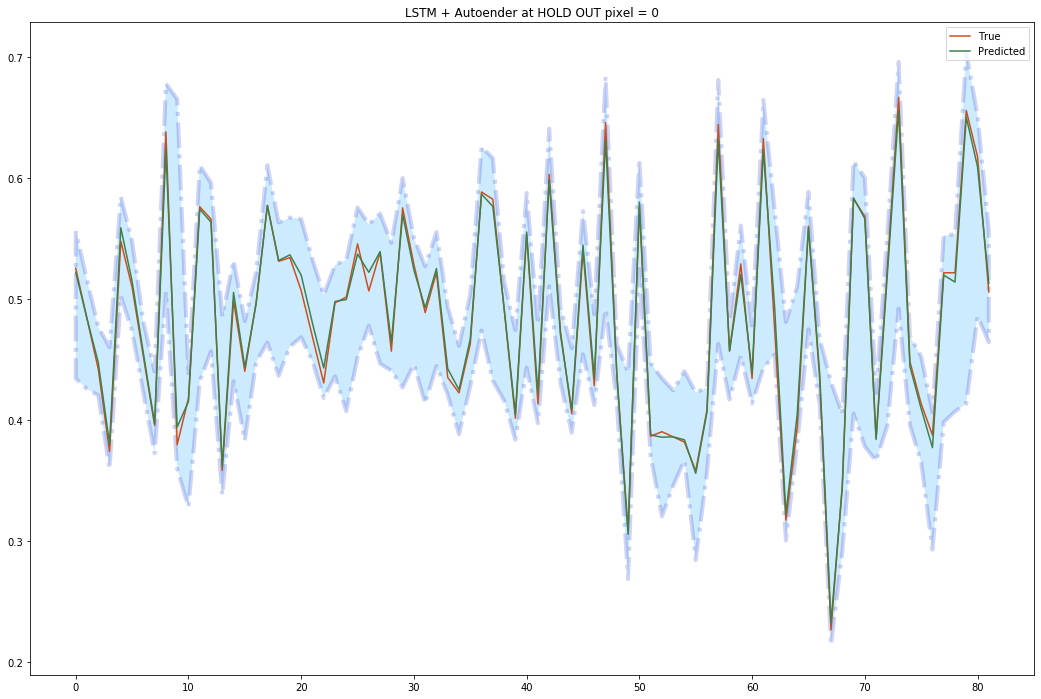

In [87]:
x = list(holdout_uncer1.index)

plt.figure(figsize=(18,12))
plt.plot(x,holdout_uncer1['true'],color='#CC4F1B')
plt.plot(x,holdout_uncer1['medium'],color = '#3F7F4C')

plt.fill_between(x,holdout_uncer1['lower'],holdout_uncer1['upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)

plt.legend(('True','Predicted'))

plt.title("LSTM + Autoender at HOLD OUT pixel = " + str(pixel))

### Summary statistics - model 1

In [89]:
### COMPUTE STOCHASTIC DROPOUT FOR SINGLE COUNTY ###
holdout_mae1_test = []

enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

_, y1_test = test_stoc_drop1(df_x_test1=val_x_train1,
                                             df_y_test1=val_y_train1,
                                             ext_x_test1=eval_x_train1,
                                             pixel = pixel, 
                                             R = dropout_rate, 
                                             enc = enc, 
                                             NN = NN) ##Single pixel location

for i in tqdm.tqdm(range(0,100)):
    
    holdout_mae1_test.append(mean_absolute_error(y1_test, test_stoc_drop1(df_x_test1=val_x_train1,
                                             df_y_test1=val_y_train1,
                                             ext_x_test1=eval_x_train1,
                                             pixel = pixel, 
                                             R = dropout_rate, 
                                             enc = enc, 
                                             NN = NN)[0]))

print(np.mean(holdout_mae1_test), np.std(holdout_mae1_test))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.48it/s]

0.0237713282973301 0.0031254328572906578


### Model 2 using hold out data

In [90]:
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])
#pred2_test, y2_test = test_stoc_drop2(df_x_test1,df_y_test1,ext_x_test1,0, 0.5, NN)

In [91]:
def holdout_uncertainty_model2(pixel,p =0.05,dropout_rate =0.5):
    
    pred1 = []
    
    for i in tqdm.tqdm(range(0,100)):
        
        pred1_test,y1_test = test_stoc_drop2(df_x_test1=val_x_train1,
                                             df_y_test1=val_y_train1,
                                             ext_x_test1=eval_x_train1,
                                             pixel = pixel,
                                             R = dropout_rate,
                                             NN =NN) ## at pixel 0
        pred1.append(pred1_test)
    
    pred1 = np.asarray(pred1)
    pp = pred1[:,:,0].T
    lower = np.quantile(pp,p/2,axis =1)
    upper = np.quantile(pp,1- p/2,axis =1)
    medium = np.quantile(pp,0.5,axis =1)

    fdf = pd.DataFrame({
        "true":y1_test.ravel(),
        "lower":lower,
        "medium":medium,
        "upper":upper
        })
    
    return fdf

In [92]:
pixel = 0
holdout_uncer2 = holdout_uncertainty_model2(pixel = pixel)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 69.76it/s]


Text(0.5, 1.0, 'LSTM model at HOLD OUT pixel = 0')

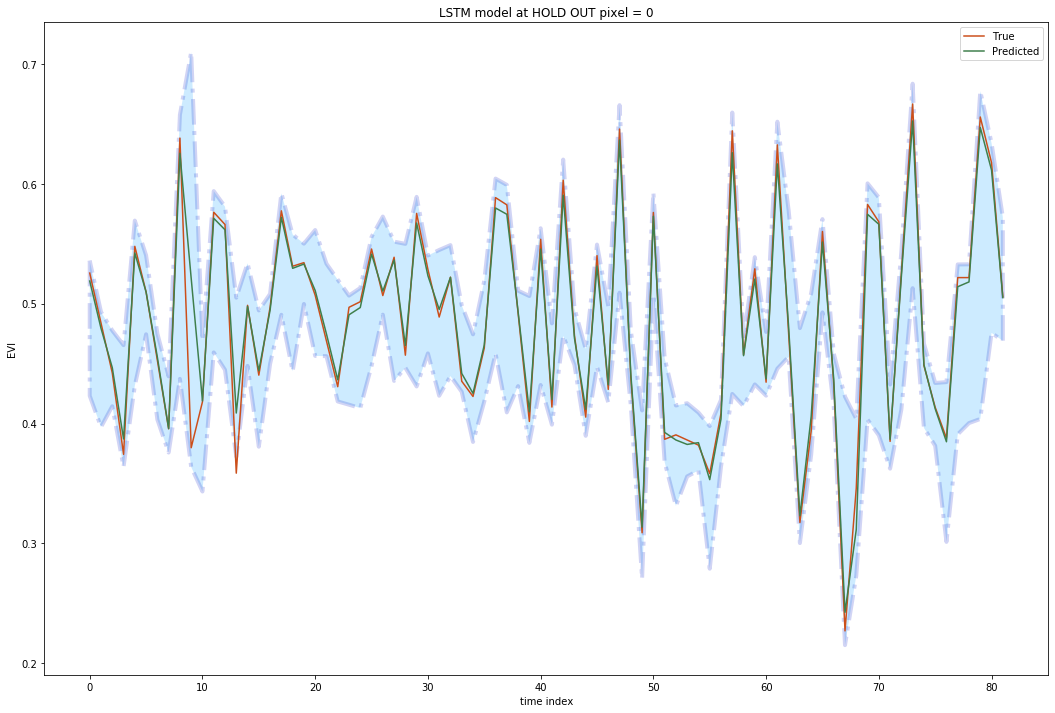

In [110]:
x = list(holdout_uncer2.index)

plt.figure(figsize=(18,12))
plt.plot(x,holdout_uncer2['true'],color='#CC4F1B')
plt.plot(x,holdout_uncer2['medium'],color = '#3F7F4C')

plt.fill_between(x,holdout_uncer2['lower'],holdout_uncer2['upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)

plt.legend(('True','Predicted'))
plt.xlabel("time index")
plt.ylabel("EVI")
plt.title("LSTM model at HOLD OUT pixel = " + str(pixel))

### Summary statistics - model 2

In [94]:
### COMPUTE STOCHASTIC DROPOUT FOR SINGLE COUNTY ###
holdout_mae2_test = []

enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])

_, y2_test = test_stoc_drop2(df_x_test1=val_x_train1,
                                             df_y_test1=val_y_train1,
                                             ext_x_test1=eval_x_train1,
                                             pixel = pixel,
                                             R = dropout_rate,
                                             NN =NN) ##Single pixel location

for i in tqdm.tqdm(range(0,100)):
    
    holdout_mae2_test.append(mean_absolute_error(y2_test, test_stoc_drop2(df_x_test1=val_x_train1,
                                             df_y_test1=val_y_train1,
                                             ext_x_test1=eval_x_train1,
                                             pixel = pixel,
                                             R = dropout_rate,
                                             NN =NN)[0]))

print(np.mean(holdout_mae2_test), np.std(holdout_mae2_test))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 93.89it/s]

0.022635181360855336 0.0036592677106921526


## 8 Evaluation using hold out data (location is unseen, time is unseen)

### Model 1

In [97]:
enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

In [98]:
def holdout_uncertainty_model11(pixel,p =0.05,dropout_rate =0.5):
    
    pred1 = []
    
    for i in tqdm.tqdm(range(0,100)):
        
        pred1_test,y1_test = test_stoc_drop1(df_x_test1=val_x_test1,
                                             df_y_test1=val_y_test11,
                                             ext_x_test1=eval_x_test1,
                                             pixel = pixel, 
                                             R = dropout_rate, 
                                             enc = enc, 
                                             NN = NN) ## at pixel 0
        pred1.append(pred1_test)
    
    pred1 = np.asarray(pred1)
    pp = pred1[:,:,0].T ##delete one dimension just assign one dimesion to 0
    lower = np.quantile(pp,p/2,axis =1)
    upper = np.quantile(pp,1- p/2,axis =1)
    medium = np.quantile(pp,0.5,axis =1)

    fdf = pd.DataFrame({
        "true":y1_test.ravel(),
        "lower":lower,
        "medium":medium,
        "upper":upper
        })
    
    return fdf

In [99]:
pixel = 0
holdout_uncer11 = holdout_uncertainty_model1(pixel = pixel)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.21it/s]


Text(0.5, 1.0, 'LSTM + Autoender at HOLD OUT (time and location unseen) pixel = 0')

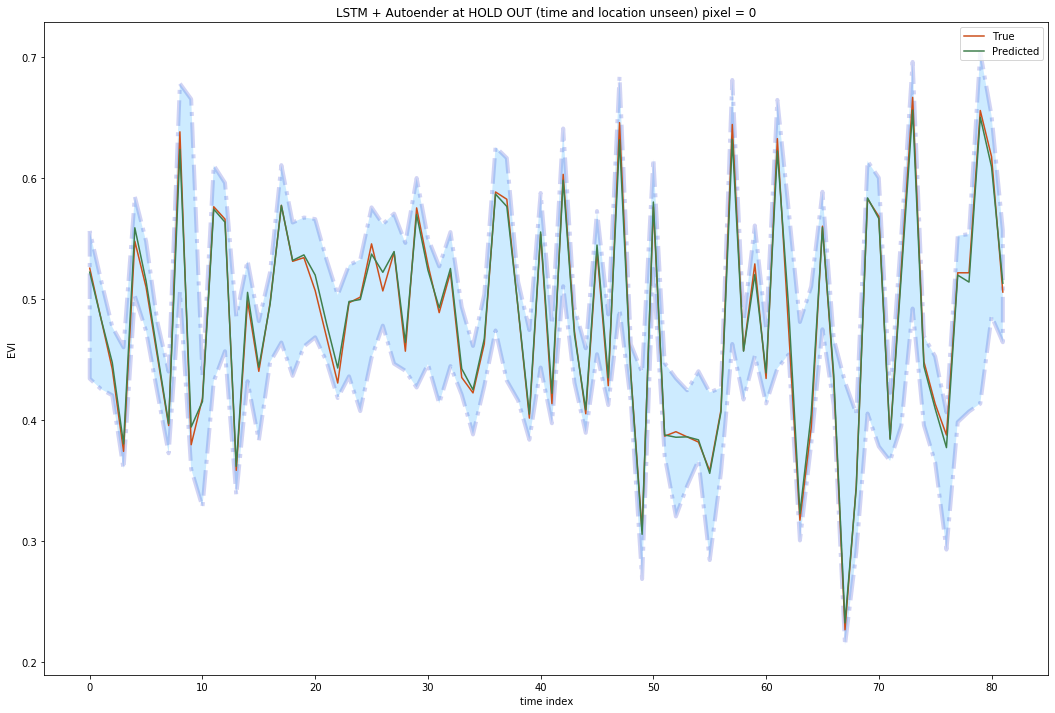

In [112]:
x = list(holdout_uncer11.index)

plt.figure(figsize=(18,12))
plt.plot(x,holdout_uncer11['true'],color='#CC4F1B')
plt.plot(x,holdout_uncer11['medium'],color = '#3F7F4C')

plt.fill_between(x,holdout_uncer11['lower'],holdout_uncer11['upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)

plt.legend(('True','Predicted'))
plt.xlabel('time index')
plt.ylabel('EVI')
plt.title("LSTM + Autoender at HOLD OUT (time and location unseen) pixel = " + str(pixel))

### Summary statistics - model 1

In [103]:
### COMPUTE STOCHASTIC DROPOUT FOR SINGLE COUNTY ###
holdout_mae11_test = []

enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

_, y1_test = test_stoc_drop1(df_x_test1=val_x_test1,
                                             df_y_test1=val_y_test1,
                                             ext_x_test1=eval_x_test1,
                                             pixel = pixel, 
                                             R = dropout_rate, 
                                             enc = enc, 
                                             NN = NN) ##Single pixel location

for i in tqdm.tqdm(range(0,100)):
    
    holdout_mae11_test.append(mean_absolute_error(y1_test, test_stoc_drop1(df_x_test1=val_x_test1,
                                             df_y_test1=val_y_test1,
                                             ext_x_test1=eval_x_test1,
                                             pixel = pixel, 
                                             R = dropout_rate, 
                                             enc = enc, 
                                             NN = NN)[0]))

print(np.mean(holdout_mae11_test), np.std(holdout_mae11_test))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.76it/s]

0.023464055293943818 0.0036691583193717387


### Model 2 using hold out data

In [105]:
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])

In [104]:
def holdout_uncertainty_model22(pixel,p =0.05,dropout_rate =0.5):
    
    pred1 = []
    
    for i in tqdm.tqdm(range(0,100)):
        
        pred1_test,y1_test = test_stoc_drop2(df_x_test1=val_x_test1,
                                             df_y_test1=val_y_test1,
                                             ext_x_test1=eval_x_test1,
                                             pixel = pixel,
                                             R = dropout_rate,
                                             NN =NN) ## at pixel 0
        pred1.append(pred1_test)
    
    pred1 = np.asarray(pred1)
    pp = pred1[:,:,0].T
    lower = np.quantile(pp,p/2,axis =1)
    upper = np.quantile(pp,1- p/2,axis =1)
    medium = np.quantile(pp,0.5,axis =1)

    fdf = pd.DataFrame({
        "true":y1_test.ravel(),
        "lower":lower,
        "medium":medium,
        "upper":upper
        })
    
    return fdf

In [106]:
pixel = 0
holdout_uncer22 = holdout_uncertainty_model22(pixel = pixel)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.87it/s]


Text(0.5, 1.0, 'LSTM model at HOLD OUT pixel = 0')

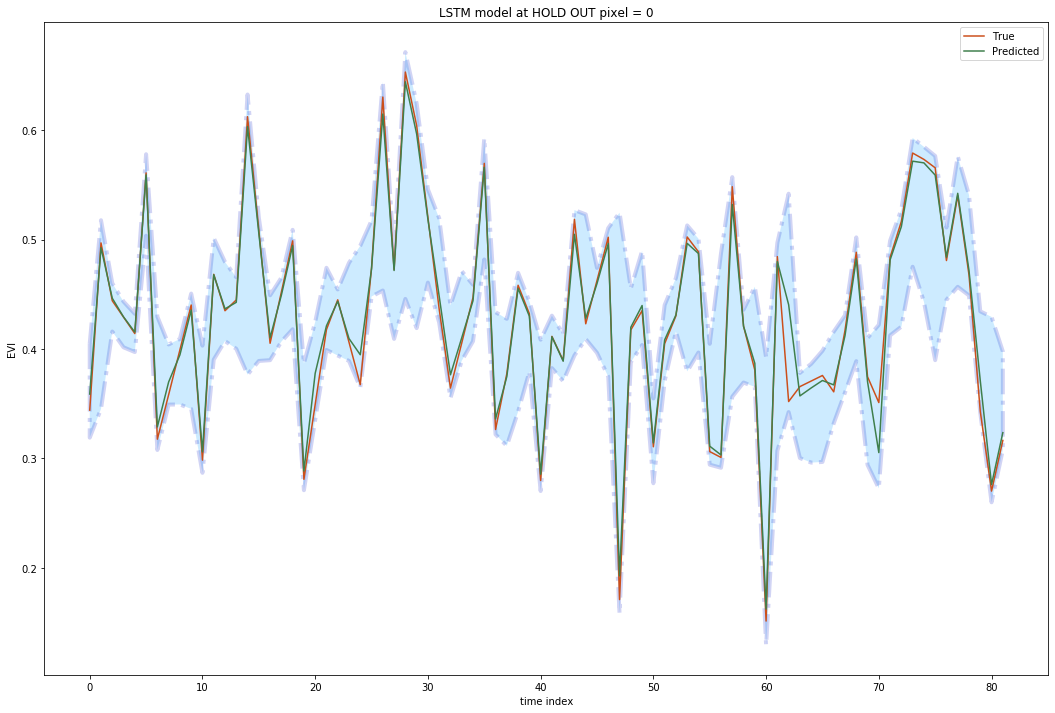

In [111]:
x = list(holdout_uncer22.index)

plt.figure(figsize=(18,12))
plt.plot(x,holdout_uncer22['true'],color='#CC4F1B')
plt.plot(x,holdout_uncer22['medium'],color = '#3F7F4C')

plt.fill_between(x,holdout_uncer22['lower'],holdout_uncer22['upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)

plt.legend(('True','Predicted'))
plt.xlabel('time index')
plt.ylabel('EVI')
plt.title("LSTM model at HOLD OUT pixel = " + str(pixel))

In [108]:
### COMPUTE STOCHASTIC DROPOUT FOR SINGLE COUNTY ###
holdout_mae22_test = []

#enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])

_, y2_test = test_stoc_drop2(df_x_test1=val_x_test1,
                                             df_y_test1=val_y_test1,
                                             ext_x_test1=eval_x_test1,
                                             pixel = pixel,
                                             R = dropout_rate,
                                             NN =NN) ##Single pixel location

for i in tqdm.tqdm(range(0,100)):
    
    holdout_mae22_test.append(mean_absolute_error(y2_test, test_stoc_drop2(df_x_test1=val_x_test1,
                                             df_y_test1=val_y_test1,
                                             ext_x_test1=eval_x_test1,
                                             pixel = pixel,
                                             R = dropout_rate,
                                             NN =NN)[0]))

print(np.mean(holdout_mae22_test), np.std(holdout_mae22_test))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 91.17it/s]

0.022831585612602328 0.0035006931574566493


## 9 Conclusion

1 From the test and validation data, we can see we can used both models capture the trend of the EVI along the time for different locations (even they are not trained in the training data).

2 At the same time, the uncertianty of our prediction can be quantified with the Bayeisan NN model. Methods and framework can be transplanted into other revelant applications. The scalability of this solution to generalize well and can avoid train multiple models for every time series

